# Exploratory Data Analysis (EDA) on Economic Indicator
Created on February 24th, 2023. 

In this notebook, we will perform the EDA on the time series dataset. There are 3 steps:
1. Installation Libraries
2. Dataset Preparation
3. EDA

##1. Installation Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from functools import reduce

## 2. Dataset Preparation
To run the shared colab notebook for the first time, files are allocated differently from the Drive owner's. Changing a directory is necessary prior to importing the dataset, and these are the processes:
1. Right click to the `DataTeam1` folder, select `Add shortcut to Drive`, and then `My Drive`.
2. Upload Dataset file to the `IndexK` folder.
3. Do read_csv on your Dataset file.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
if os.getcwd() == '/content':
  os.chdir('drive/MyDrive/DataTeam1/Index1')

Mounted at /content/drive


In [3]:
import_df = pd.read_csv('T10Y2Y.csv') #Dataset file
import_df.head(5)

,DATE,T10Y2Y
0,1976-06-01,0.68
1,1976-06-02,0.71
2,1976-06-03,0.70
3,1976-06-04,0.77
4,1976-06-07,0.79


In [4]:
recession = pd.read_csv('../Index7/Recession.csv')
recession.head(5)

,DATE,JHDUSRGDPBR
0,1967-10-01,0.0
1,1968-01-01,0.0
2,1968-04-01,0.0
3,1968-07-01,0.0
4,1968-10-01,0.0


## 3. EDA
The analysis can be conducted at any timeline frequency, including, daily, weekly, and monthly. You can select any methods for analysis, in which the keyword for searching is 'Time series analysis'. 

To-do tasks:
1. Visualize the output
2. Discuss/analyze the result

Update meeting on March 2nd, 2023.

In [24]:
df = import_df.copy()
df['DATE'] = pd.to_datetime(df['DATE'])
df.columns = ['DATE', 'T10Y2Y']
df["T10Y2Y"] = pd.to_numeric(df['T10Y2Y'], errors='coerce')
df.set_index('DATE', inplace=True)
df

,T10Y2Y
DATE,
1976-06-01,0.68
1976-06-02,0.71
1976-06-03,0.70
1976-06-04,0.77
1976-06-07,0.79
...,...
2023-02-22,-0.73
2023-02-23,-0.78
2023-02-24,-0.83


In [6]:
recession.columns = ['DATE', 'recession']
recession['DATE'] = pd.to_datetime(recession['DATE'])
start = []
end = []
for i, date in enumerate(recession.DATE):
  if i == 0 or i==len(recession.DATE)-1:
    continue
  if (recession.recession[i-1] == 0) & (recession.recession[i] == 1):
    start.append(date)
  elif (recession.recession[i] == 1) & (recession.recession[i+1] == 0):
    end.append(date)
print(start)
print(end)

[Timestamp('1969-04-01 00:00:00'), Timestamp('1973-10-01 00:00:00'), Timestamp('1979-04-01 00:00:00'), Timestamp('1981-04-01 00:00:00'), Timestamp('1989-10-01 00:00:00'), Timestamp('2001-01-01 00:00:00'), Timestamp('2007-10-01 00:00:00'), Timestamp('2020-01-01 00:00:00')]
[Timestamp('1970-10-01 00:00:00'), Timestamp('1975-01-01 00:00:00'), Timestamp('1980-04-01 00:00:00'), Timestamp('1982-04-01 00:00:00'), Timestamp('1991-01-01 00:00:00'), Timestamp('2001-07-01 00:00:00'), Timestamp('2009-04-01 00:00:00'), Timestamp('2020-04-01 00:00:00')]


In [14]:
start = start[2:]
end = end[2:]
Reces = pd.DataFrame()
Reces['start'] = start
Reces['end'] = end
Reces

,start,end
0,1979-04-01,1980-04-01
1,1981-04-01,1982-04-01
2,1989-10-01,1991-01-01
3,2001-01-01,2001-07-01
4,2007-10-01,2009-04-01
5,2020-01-01,2020-04-01


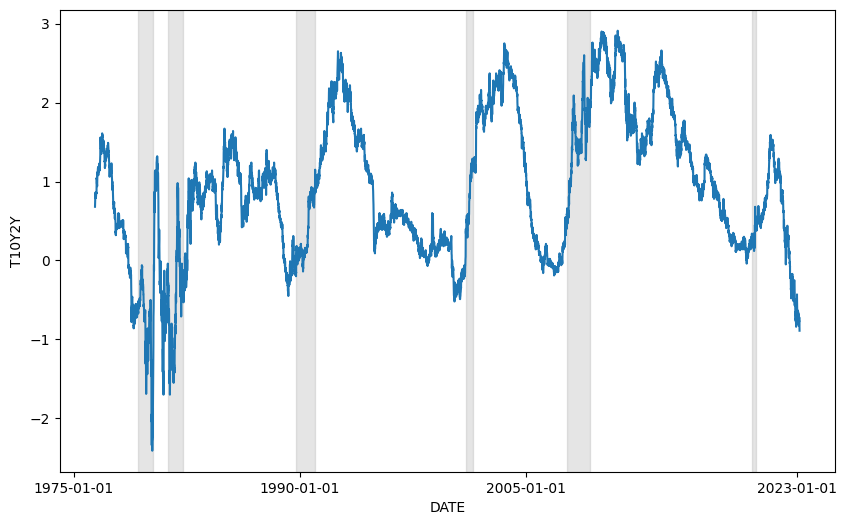

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='DATE', y='T10Y2Y', data=df)
for i in range(len(start)):
  ax.axvspan(start[i], end[i], color='grey', alpha=0.2)

plt.xticks(['1975-01-01','1990-01-01', '2005-01-01', '2023-01-01'])
plt.show()

In [20]:
def calc_TP_FP_rate(y_true, y_pred):
    
    # Convert predictions to series with index matching y_true
    y_pred = pd.Series(y_pred, index=y_true.index)
    
    # Instantiate counters
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in y_true.index: 
        if y_true[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_true[i]!=y_pred[i]:
           FP += 1
        if y_true[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_true[i]!=y_pred[i]:
           FN += 1
    
    # Calculate true positive rate and false positive rate
    tpr = TP / (TP + FN)
    fpr = FP / (FP + TN)

    return tpr, fpr

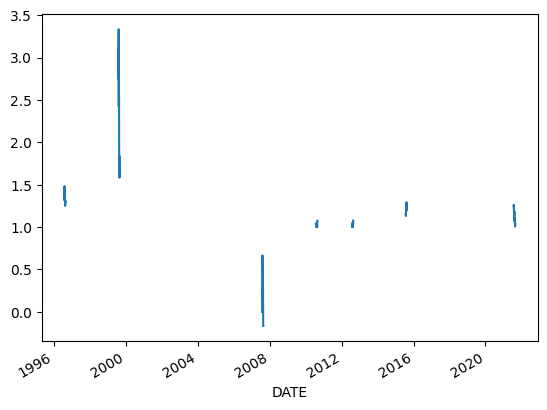

In [51]:
tot = []

for i in range(3,4):
  dfi = df.copy()
  dfi.index = dfi.index + dt.timedelta(days=i*30)

  dfi['MIN_1Y'] = np.nan
  for i in range(len(dfi)):
    if i >= 11:
      arr = np.array(dfi['T10Y2Y'])
      indices = [i-k for k in range(52)]
      take = np.take(arr, indices)
      dfi.iloc[i,1] = take.min()
    else:
      dfi.iloc[i,1] = np.nan

  dfi['CHG'] = (dfi['T10Y2Y'])/dfi['MIN_1Y']
  dfi['CHG'].plot()
  li = []
  for i in range(len(Reces)):
    li.append(dfi.reset_index()['DATE'].apply(lambda x: int((x > Reces.loc[i]['start'])&(x < Reces.loc[i]['end']))))
  test = reduce(lambda x,y:x+y, li)
  dfi['recession'] = test.values.copy()
  # Containers for true positive / false positive rates
  tp_rates = []
  fp_rates = []

  threshold = np.linspace(1.00,1.5,num=25)

  # Find true positive / false positive rate for each threshold
  for t in threshold:
      
      dfi['predict'] = dfi['CHG'].apply(lambda x: int(x>=t))
      tp_rate, fp_rate = calc_TP_FP_rate(dfi['recession'], dfi['predict'])
          
      tp_rates.append(tp_rate)
      fp_rates.append(fp_rate)
  
  tot.append([fp_rates, tp_rates])

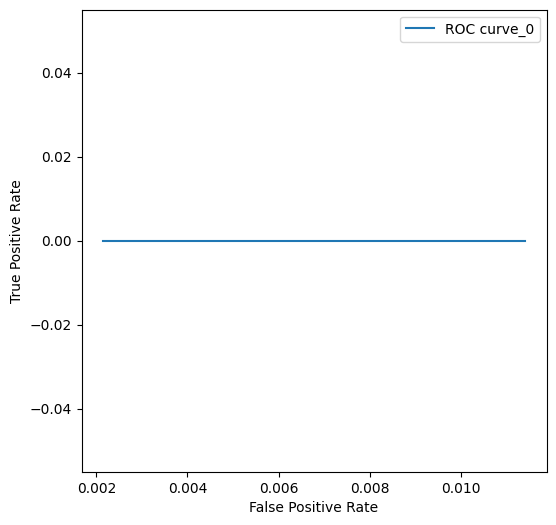

In [52]:
fig, ax = plt.subplots(figsize=(6,6))
for i in range(len(tot)):
  ax.plot(tot[i][0], tot[i][1], label=f'ROC curve_{i}')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

auc score for 0 month(s) prediction 0.002969137494495102


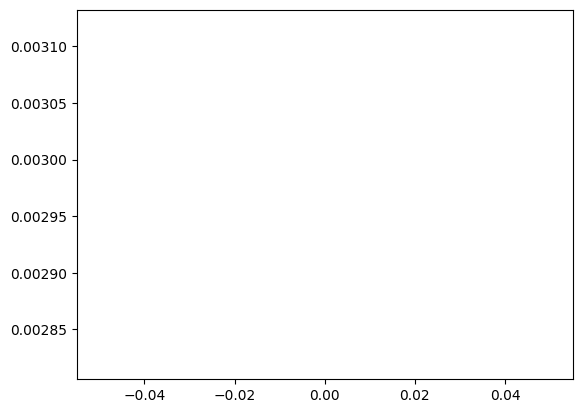

In [37]:
from sklearn.metrics import auc
auc_x = []
auc_y = []
for i in range(len(tot)):
  auc_x.append(i)
  auc_y.append(auc(tot[i][0], tot[i][1]))
  print(f'auc score for {i} month(s) prediction {auc_y[i]}')
plt.plot(auc_x, auc_y)

In [ ]:
max = [0,0, -9999]
for k in range(10,13): # tried 9 - 12
  for i in range(36,60):  # tried 12-59
    df4 = df.copy()
    df4.index = df4.DATE + dt.timedelta(days=k*30)
    df4 = df4.drop('DATE', axis=1)
    df4['pct'] = df4['wage'].pct_change(periods=i)

    li = []
    for j in range(len(Reces)):
      li.append(df4.reset_index()['DATE'].apply(lambda x: int((x > Reces.loc[j]['start'])&(x < Reces.loc[j]['end']))))
    test = reduce(lambda x,y:x+y, li)
    df4['recession'] = test.values.copy()
    df4
    # Containers for true positive / false positive rates
    tp_rates = []
    fp_rates = []

    threshold = np.linspace(0,1,num=100)

    # Find true positive / false positive rate for each threshold
    for t in threshold:
        
        df4['predict'] = df4['pct'].apply(lambda x: int(x>t))
        tp_rate, fp_rate = calc_TP_FP_rate(df4['recession'], df4['predict'])
            
        tp_rates.append(tp_rate)
        fp_rates.append(fp_rate)
    au = auc(fp_rates, tp_rates)
    if au > max[2]:
      max[0] = k
      max[1] = i
      max[2] = au
  print(k)
print(max)

10
11
12
[10, 36, 0.7393864013266997]


In [ ]:
for k in range(5,16):
  for i in range(32,41):
    df3 = df.copy()
    df3.index = df3.DATE + dt.timedelta(days=k*30)
    df3 = df3.drop('DATE', axis=1)
    df3['pct'] = df3['wage'].pct_change(periods=i)

    li = []
    for j in range(len(Reces)):
      li.append(df3.reset_index()['DATE'].apply(lambda x: int((x > Reces.loc[j]['start'])&(x < Reces.loc[j]['end']))))
    test = reduce(lambda x,y:x+y, li)
    df3['recession'] = test.values.copy()
    data_group1 = df3[df3['recession'] == 1]['pct'].dropna().to_numpy()
    data_group2 = df3[df3['recession'] == 0]['pct'].dropna().to_numpy()
    # Conducting two-sample ttest
    p = stats.ttest_ind(a=data_group1, b=data_group2, equal_var=True).pvalue
    if p < 0.01:
      print(f'for {k} months shift, pct periods = {i}, p-value: {p}')

for 5 months shift, pct periods = 32, p-value: 2.9850637824778807e-21
for 5 months shift, pct periods = 33, p-value: 1.6007166355662061e-21
for 5 months shift, pct periods = 34, p-value: 1.1458489224127869e-21
for 5 months shift, pct periods = 35, p-value: 1.3174329215457428e-21
for 5 months shift, pct periods = 36, p-value: 1.5581645859718581e-21
for 5 months shift, pct periods = 37, p-value: 1.7899006811358013e-21
for 5 months shift, pct periods = 38, p-value: 1.9437676410413357e-21
for 5 months shift, pct periods = 39, p-value: 1.8779288137864124e-21
for 5 months shift, pct periods = 40, p-value: 1.6160243962313706e-21
for 6 months shift, pct periods = 32, p-value: 6.364867585216257e-22
for 6 months shift, pct periods = 33, p-value: 5.388110789864496e-22
for 6 months shift, pct periods = 34, p-value: 4.0773630693963603e-22
for 6 months shift, pct periods = 35, p-value: 4.710448012847608e-22
for 6 months shift, pct periods = 36, p-value: 5.748420010826714e-22
for 6 months shift, pct 